
## Approach:

1. Preprocess dataset with 45,000 tweets - Cleanup, lemmatization, encoding
2. Train 3 models and chose the best one
3. Test model on real time tweets and Google news dataset
4. Display results - sentiment and wordcloud

In [ ]:
# Import modules
import requests
import json
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import numpy as np

## Step 1: Load dataset

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/Datasets/Corona_NLP_train.csv',
                 encoding='latin1',parse_dates=['TweetAt'])

In [ ]:
df.head()

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
0,3799,48751,London,2020-03-16,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Neutral
1,3800,48752,UK,2020-03-16,advice Talk to your neighbours family to excha...,Positive
2,3801,48753,Vagabonds,2020-03-16,Coronavirus Australia: Woolworths to give elde...,Positive
3,3802,48754,NaN,2020-03-16,My food stock is not the only one which is emp...,Positive
4,3803,48755,NaN,2020-03-16,"Me, ready to go at supermarket during the #COV...",Extremely Negative


## Step 2: Data analysis

In [ ]:
# Dimensions of data
print("\n Shape:",df.shape)  
print("\n Dimensions:",df.ndim)
# Size of data
print("\n Size:",df.size)    
print("\n Count of empty fields:\n",df.isna().sum())
print("\n Summary of dataset:")
print(df.info())


 Shape: (41157, 6)

 Dimensions: 2

 Size: 246942

 Count of empty fields:
 UserName            0
ScreenName          0
Location         8590
TweetAt             0
OriginalTweet       0
Sentiment           0
dtype: int64

 Summary of dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41157 entries, 0 to 41156
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   UserName       41157 non-null  int64         
 1   ScreenName     41157 non-null  int64         
 2   Location       32567 non-null  object        
 3   TweetAt        41157 non-null  datetime64[ns]
 4   OriginalTweet  41157 non-null  object        
 5   Sentiment      41157 non-null  object        
dtypes: datetime64[ns](1), int64(2), object(3)
memory usage: 1.9+ MB
None


In [ ]:
# Display count and unique value counts in columns, include text ones
df.describe(include='O')

,Location,OriginalTweet,Sentiment
count,32567,41157,41157
unique,12220,41157,5
top,London,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Positive
freq,540,1,11422


In [ ]:
df.Sentiment.value_counts()

Positive              11422
Negative               9917
Neutral                7713
Extremely Positive     6624
Extremely Negative     5481
Name: Sentiment, dtype: int64

Displaying words commonly seen in training data

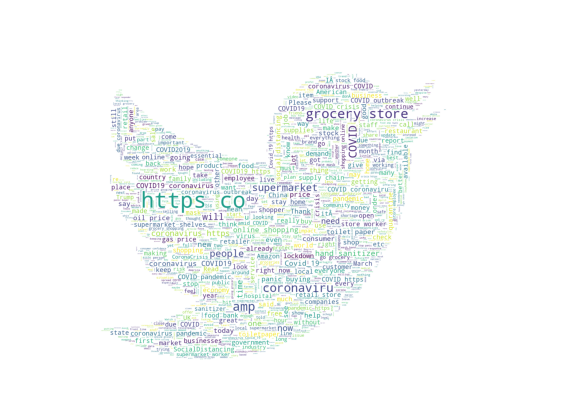

In [ ]:
import wordcloud
from skimage.io import imread
twitter_mask = imread('https://static01.nyt.com/images/2014/08/10/magazine/10wmt/10wmt-superJumbo-v4.jpg')
# Displaying most commonly occuring words
wordcloud = wordcloud.WordCloud(stopwords=wordcloud.STOPWORDS, max_font_size=80, max_words=5000,mask=twitter_mask, 
                                background_color='white').generate(' '.join(txt for txt in df["OriginalTweet"]))
fig, ax = plt.subplots(figsize=(10,10))
ax.imshow(wordcloud, interpolation='bilinear')
ax.set_axis_off()
plt.imshow(wordcloud)

In [ ]:
# Get count of null columns in dataset
def getNullCount(dataset):
    nullCount=[pd.isnull(dataset[x]).sum() for x in dataset.columns]
    return dict(zip(dataset.columns,nullCount))

In [ ]:
# Location has maximum null values, but irrelevant to sentiment of tweet
getNullCount(df)

{'Location': 8590,
 'OriginalTweet': 0,
 'ScreenName': 0,
 'Sentiment': 0,
 'TweetAt': 0,
 'UserName': 0}

In [ ]:
# Distribution of sentiment
fig = px.bar(x = np.unique(df["Sentiment"]),
y = [list(df["Sentiment"]).count(i) for i in np.unique(df["Sentiment"])] , 
            color = np.unique(df["Sentiment"]),
             color_continuous_scale="Emrld") 
fig.update_xaxes(title="Sentiment")
fig.update_yaxes(title = "Number of Rows")
fig.update_layout(showlegend = False,
    title = {
        'text': 'Sentiment Distribution',
        'y':0.95,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'})
fig.show()

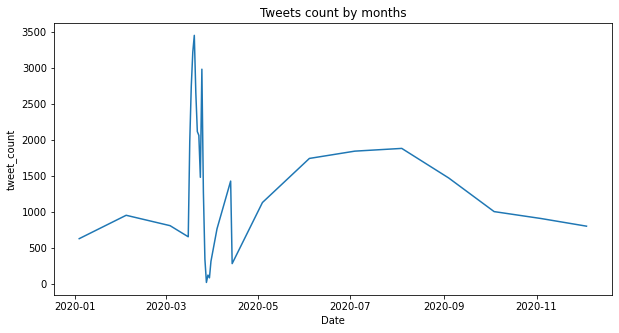

In [ ]:
# Distribution of tweets in the year
plt.figure(figsize = (10, 5))
tweets_daily = df.groupby(["TweetAt"])["OriginalTweet"].count().reset_index()
tweets_daily.columns = ['Date', 'tweet_count']
sns.lineplot(x = 'Date', y = 'tweet_count', hue = None, data = tweets_daily)
plt.title('Tweets count by months')
plt.show()

## Step 3: Data preprocessing

Extremely negative and extremely positive can be combined into negative and positive respectivley, to avoid confusion

In [ ]:
df.Sentiment = df.Sentiment.replace({'Extremely Negative': 'Negative',
                                     'Extremely Positive': 'Positive'})

In [ ]:
# Distribution of sentiment after merge to get 3 categories
fig = px.bar(x = np.unique(df["Sentiment"]),
y = [list(df["Sentiment"]).count(i) for i in np.unique(df["Sentiment"])] , 
            color = np.unique(df["Sentiment"]),
             color_continuous_scale="Emrld") 
fig.update_xaxes(title="Sentiment")
fig.update_yaxes(title = "Number of Rows")
fig.update_layout(showlegend = False,
    title = {
        'text': 'Sentiment Distribution',
        'y':0.95,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'})
fig.show()

In [ ]:
df.head()

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
0,3799,48751,London,2020-03-16,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Neutral
1,3800,48752,UK,2020-03-16,advice Talk to your neighbours family to excha...,Positive
2,3801,48753,Vagabonds,2020-03-16,Coronavirus Australia: Woolworths to give elde...,Positive
3,3802,48754,NaN,2020-03-16,My food stock is not the only one which is emp...,Positive
4,3803,48755,NaN,2020-03-16,"Me, ready to go at supermarket during the #COV...",Negative


In [ ]:
# Drop location as it has maximum null values and does not affect results
df.drop(columns='Location', inplace=True)
df.head()

,UserName,ScreenName,TweetAt,OriginalTweet,Sentiment
0,3799,48751,2020-03-16,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Neutral
1,3800,48752,2020-03-16,advice Talk to your neighbours family to excha...,Positive
2,3801,48753,2020-03-16,Coronavirus Australia: Woolworths to give elde...,Positive
3,3802,48754,2020-03-16,My food stock is not the only one which is emp...,Positive
4,3803,48755,2020-03-16,"Me, ready to go at supermarket during the #COV...",Negative


## Step 4: Test-train split

In [ ]:
from sklearn.model_selection import train_test_split
# train_text is string and train_label is sentiment as Positive/Negative/Neutral
train_text, val_text, train_label, val_label = train_test_split(df.OriginalTweet, df.Sentiment, test_size=0.15, random_state=42)
print('Training tweets shape: ',train_text.shape)
print('Training data size: ',len(train_text))
print('Testing tweets shape: ',val_text.shape)
print('Testing data size: ',len(val_text))

Training tweets shape:  (34983,)
Training data size:  34983
Testing tweets shape:  (6174,)
Testing data size:  6174


In [ ]:
# Label encoder is used to map Positive, Negative or Neutral to classes
from sklearn.preprocessing import LabelEncoder
labels = LabelEncoder()
train_label_encoded = labels.fit_transform(train_label)
# Classes are 0,1,2
print(train_label_encoded)

[2 2 1 ... 0 1 0]


In [ ]:
# Print labels and their encoded numbers
print("Classes are: ", labels.classes_)
print("Labels are: ", labels.transform(['Negative','Neutral','Positive']))

Classes are:  ['Negative' 'Neutral' 'Positive']
Labels are:  [0 1 2]


## Step 5: Lemmatization and Count vectorization

In [ ]:
import re
class Lemmatizer(object):
    def __init__(self):
        self.lemmatizer = WordNetLemmatizer()
    def __call__(self, sentence):
      # removing mentions
      sentence = re.sub("@[A-za-z0-9]+", "", sentence) 
      # removing RT that stands for re-tweets 
      sentence = re.sub("RT[\s]+", "", sentence) 
      # Replace hyperlinks by space
      sentence = re.sub("https?:\/\/\S+", "", sentence)
      # removing nextline characters
      sentence = re.sub("\n","",sentence) 
      # Split words to return individual words or tokens
      return [self.lemmatizer.lemmatize(word) for word in sentence.split() if len(word)>1]

In [ ]:
# Natural Language Toolkit libraries
import nltk
from nltk.stem import WordNetLemmatizer
from tqdm import tqdm
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


True

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
# Remove commonly occuring english words called stopwords and convert to lowercase
tokenizer = CountVectorizer(max_features=5000, stop_words='english', lowercase=True, tokenizer=Lemmatizer())

In [ ]:
train_x = tokenizer.fit_transform(train_text).toarray()

/usr/local/lib/python3.7/dist-packages/sklearn/feature_extraction/text.py:401: UserWarning:

Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ha', 'le', 'u', 'wa'] not in stop_words.



<BarContainer object of 15 artists>

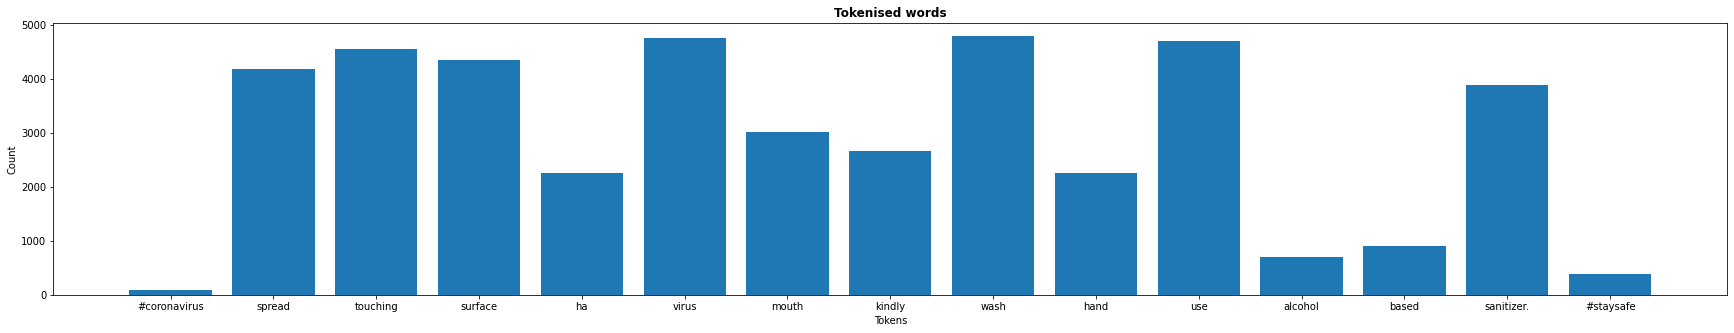

In [ ]:
# List of commonly occuring words in tweets
vocabulary = tokenizer.vocabulary_

out = dict(list(vocabulary.items())[0: 15]) 
# Plot 15 words tokenised from the tweets
plt.figure(figsize = (30, 5))
plt.xlabel('Tokens')
plt.ylabel('Count')
plt.title('Tokenised words', weight='bold')
plt.bar(out.keys(), out.values())

In [ ]:
tokenizer.get_params()

{'analyzer': 'word',
 'binary': False,
 'decode_error': 'strict',
 'dtype': numpy.int64,
 'encoding': 'utf-8',
 'input': 'content',
 'lowercase': True,
 'max_df': 1.0,
 'max_features': 5000,
 'min_df': 1,
 'ngram_range': (1, 1),
 'preprocessor': None,
 'stop_words': 'english',
 'strip_accents': None,
 'token_pattern': '(?u)\\b\\w\\w+\\b',
 'tokenizer': <__main__.Lemmatizer at 0x7f35083c39d0>,
 'vocabulary': None}

In [ ]:
feature_names = tokenizer.get_feature_names_out()
print('Found total features in tweets: ',len(feature_names))

Found total features in tweets:  5000


In [ ]:
# Tokenization of validation data
val_x = tokenizer.transform(val_text).toarray()
val_label_codes = labels.transform(val_label)

## Step 6: Model training

1. Logistic regression - Linear model
2. XGBoost
3. Random Forest regressor

In [ ]:
!pip install xgboost

In [ ]:
# Import modules
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import MinMaxScaler

### Logistic regression

In [ ]:
logr = LogisticRegression()
logr_model = logr.fit(train_x, train_label_encoded)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



Logistic regression Validation classification report:
               precision    recall  f1-score   support

           0       0.79      0.75      0.77      2306
           1       0.65      0.69      0.67      1176
           2       0.80      0.81      0.81      2692

    accuracy                           0.77      6174
   macro avg       0.75      0.75      0.75      6174
weighted avg       0.77      0.77      0.77      6174

Logistic regression Training classification report:
               precision    recall  f1-score   support

           0       0.88      0.86      0.87     13092
           1       0.80      0.84      0.82      6537
           2       0.89      0.89      0.89     15354

    accuracy                           0.87     34983
   macro avg       0.86      0.86      0.86     34983
weighted avg       0.87      0.87      0.87     34983

Logistic regression Training accuracy:  86.89935111339794 %
Logistic regression Validation accuracy:  76.72497570456754 %
Logistic

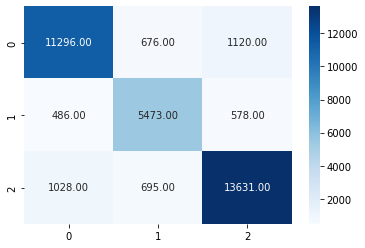

In [ ]:
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
y_pred_train = logr_model.predict(train_x)
y_pred_val = logr_model.predict(val_x)
print('Logistic regression Validation classification report:\n',classification_report(val_label_codes, y_pred_val))
print('Logistic regression Training classification report:\n',classification_report(train_label_encoded, y_pred_train ))
print('Logistic regression Training accuracy: ',accuracy_score(train_label_encoded, y_pred_train)*100,'%')
print('Logistic regression Validation accuracy: ',accuracy_score(val_label_codes, y_pred_val)*100,'%')
cm = confusion_matrix(train_label_encoded, y_pred_train)
print('Logistic regression Confusion matrix:\n',cm)
sns.heatmap(cm, annot=True, fmt=".2f", cmap='Blues')

### XGBoost

In [ ]:
xg_reg = XGBClassifier(objective ='reg:linear', colsample_bytree = 0.3, learning_rate = 0.1, max_depth = 5, alpha = 10, n_estimators = 10)

In [ ]:
xg_reg.fit(train_x, train_label_encoded)
y_pred_train = xg_reg.predict(train_x)

In [ ]:
y_pred_val= xg_reg.predict(val_x)
print(y_pred_val)

[0 0 2 ... 2 2 2]


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` param

XGBoost Validation classification report:
               precision    recall  f1-score   support

           0       0.78      0.33      0.47      2306
           1       0.00      0.00      0.00      1176
           2       0.49      0.94      0.64      2692

    accuracy                           0.54      6174
   macro avg       0.42      0.43      0.37      6174
weighted avg       0.51      0.54      0.46      6174

XGBoost Training classification report:
               precision    recall  f1-score   support

           0       0.78      0.35      0.48     13092
           1       0.00      0.00      0.00      6537
           2       0.49      0.94      0.65     15354

    accuracy                           0.54     34983
   macro avg       0.42      0.43      0.38     34983
weighted avg       0.51      0.54      0.46     34983

XGBoost Training Accuracy:  54.16059228768258 %
XGBoost Validation Accuracy:  53.61192095885974 %


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



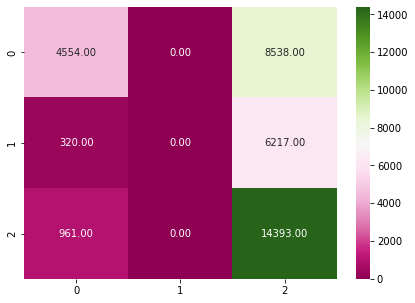

In [ ]:
# Following code give a warning for category 2 because Negative statements are not seen in val data
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

print('XGBoost Validation classification report:\n',classification_report(val_label_codes, y_pred_val))
print('XGBoost Training classification report:\n',classification_report(train_label_encoded, y_pred_train))
print('XGBoost Training Accuracy: ',accuracy_score(train_label_encoded, y_pred_train)*100,'%')
print('XGBoost Validation Accuracy: ',accuracy_score(val_label_codes, y_pred_val)*100,'%')

cm = confusion_matrix(train_label_encoded, y_pred_train)
plt.figure(figsize=(7,5))
sns.heatmap(cm,annot=True, fmt= ".2f", cmap="PiYG")

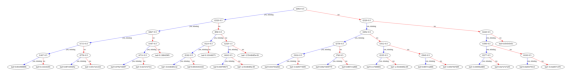

In [ ]:
# Plot tree predicted by XGBoost
import matplotlib.pyplot as plt
import xgboost as xgb

xgb.plot_tree(xg_reg,num_trees=0)
plt.rcParams['figure.figsize'] = [10, 5]
plt.show()

### Random Forest Classifier

In [ ]:
clf = RandomForestClassifier(max_depth=2, random_state=0)

In [ ]:
clf.fit(train_x, train_label_encoded)
y_pred_train = clf.predict(train_x)
y_pred_val = clf.predict(val_x)

In [ ]:
# Following code give a warning for category 2 because Negative statements are not seen in val data
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

print('Random Forest Validation classification report:\n',classification_report(val_label_codes, y_pred_val))
print('Random Forest Training classification report:\n',classification_report(train_label_encoded, y_pred_train))
print('Random Forest Training Accuracy: ',accuracy_score(train_label_encoded, y_pred_train)*100,'%')
print('Random Forest Validation Accuracy: ',accuracy_score(val_label_codes, y_pred_val)*100,'%')


Random Forest Validation classification report:
               precision    recall  f1-score   support

           0       1.00      0.00      0.01      2306
           1       0.00      0.00      0.00      1176
           2       0.44      1.00      0.61      2692

    accuracy                           0.44      6174
   macro avg       0.48      0.33      0.21      6174
weighted avg       0.56      0.44      0.27      6174

Random Forest Training classification report:
               precision    recall  f1-score   support

           0       0.97      0.01      0.01     13092
           1       0.00      0.00      0.00      6537
           2       0.44      1.00      0.61     15354

    accuracy                           0.44     34983
   macro avg       0.47      0.34      0.21     34983
weighted avg       0.56      0.44      0.27     34983

Random Forest Training Accuracy:  44.08998656490296 %
Random Forest Validation Accuracy:  43.780369290573375 %


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` param

### Gaussian and Multinomial Naive Bayes 

In [ ]:
from sklearn.naive_bayes import GaussianNB,MultinomialNB
GNB = GaussianNB()
MNB = MultinomialNB()
gnb_model = GNB.fit(train_x, train_label_encoded)
mnb_model = MNB.fit(train_x, train_label_encoded)

Gaussian Naive bayes Validation classification report:
               precision    recall  f1-score   support

           0       0.69      0.40      0.51      2306
           1       0.29      0.90      0.44      1176
           2       0.76      0.32      0.45      2692

    accuracy                           0.46      6174
   macro avg       0.58      0.54      0.47      6174
weighted avg       0.64      0.46      0.47      6174

Gaussian Naive bayes Training classification report:
               precision    recall  f1-score   support

           0       0.76      0.45      0.56     13092
           1       0.31      0.98      0.47      6537
           2       0.85      0.36      0.51     15354

    accuracy                           0.51     34983
   macro avg       0.64      0.59      0.51     34983
weighted avg       0.72      0.51      0.52     34983

Gaussian Naive bayes Training Accuracy:  50.7103450247263 %
Gaussian Naive bayes Validation Accuracy:  46.25850340136054 %


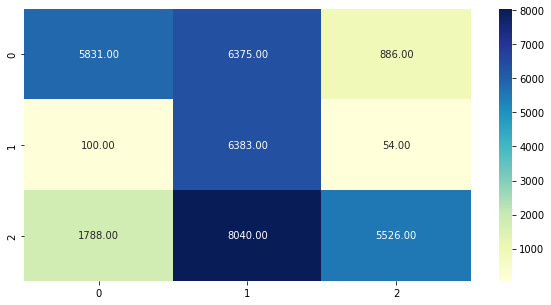

In [ ]:
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
y_pred_val = gnb_model.predict(val_x)
y_pred_train = gnb_model.predict(train_x)
print('Gaussian Naive bayes Validation classification report:\n',classification_report(val_label_codes, y_pred_val))
print('Gaussian Naive bayes Training classification report:\n',classification_report(train_label_encoded, y_pred_train))
print('Gaussian Naive bayes Training Accuracy: ',accuracy_score(train_label_encoded, y_pred_train)*100,'%')
print('Gaussian Naive bayes Validation Accuracy: ',accuracy_score(val_label_codes, y_pred_val)*100,'%')

cm = confusion_matrix(train_label_encoded, y_pred_train)
sns.heatmap(cm,annot=True, fmt= ".2f", cmap="YlGnBu")

Multinomial Naive bayes Validation classification report:
               precision    recall  f1-score   support

           0       0.70      0.71      0.70      2306
           1       0.53      0.50      0.52      1176
           2       0.72      0.73      0.73      2692

    accuracy                           0.68      6174
   macro avg       0.65      0.65      0.65      6174
weighted avg       0.68      0.68      0.68      6174

Multinomial Naive bayes Training classification report:
               precision    recall  f1-score   support

           0       0.74      0.75      0.74     13092
           1       0.60      0.61      0.61      6537
           2       0.77      0.76      0.76     15354

    accuracy                           0.73     34983
   macro avg       0.70      0.70      0.70     34983
weighted avg       0.73      0.73      0.73     34983

Multinomial Naive bayes Training Accuracy:  72.60097761770002 %
Multinomial Naive bayes Validation Accuracy:  67.816650469

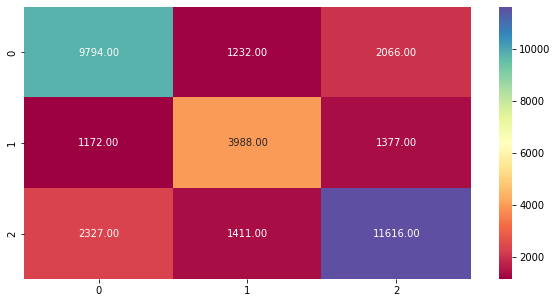

In [ ]:
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
y_pred_val = mnb_model.predict(val_x)
y_pred_train = mnb_model.predict(train_x)
print('Multinomial Naive bayes Validation classification report:\n',classification_report(val_label_codes, y_pred_val))
print('Multinomial Naive bayes Training classification report:\n',classification_report(train_label_encoded, y_pred_train))
print('Multinomial Naive bayes Training Accuracy: ',accuracy_score(train_label_encoded, y_pred_train)*100,'%')
print('Multinomial Naive bayes Validation Accuracy: ',accuracy_score(val_label_codes, y_pred_val)*100,'%')

cm = confusion_matrix(train_label_encoded, y_pred_train)
sns.heatmap(cm, annot=True, fmt=".2f", cmap="Spectral")

## Step 7: Save best model to pickle file
Logistic regression is saved as pickle file, so testing can be done on real time data

In [ ]:
import pickle
# save the model to disk
filename = 'finalized_model.pkl'
pickle.dump(logr_model, open(filename, 'wb'))

## Step 8: Test on real data

Get public sentiment of omicron through **Twitter** and **Google news** APIs to corroborate if public reaction is similar to news coverage

References:
1. https://towardsdatascience.com/detecting-fake-news-with-and-without-code-dd330ed449d9
2. https://towardsdatascience.com/twitter-sentiment-analysis-based-on-news-topics-during-covid-19-c3d738005b55
3. Compare formal news to public opinion: https://www.sciencedirect.com/science/article/pii/S2352340920310738

4. https://towardsdatascience.com/how-to-build-a-dataset-from-twitter-using-python-tweepy-861bdbc16fa5
